In [46]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import sys
sys.path.append('../src')

import numpy as np
import random
import tensorflow as tf

import matplotlib.pyplot as plt

In [47]:
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

DEFAULT_COLORS = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
fm_offset = -0

In [48]:
feature_maps = tf.Variable(tf.random.uniform((3, 8, 8, 2048), minval=0, maxval=10))
print(feature_maps.shape)

roi_boxes = tf.Variable(tf.random.uniform((3, 4, 4), minval=0, maxval=7))

x1, y1, x2, y2 = tf.unstack(roi_boxes, axis=-1)
x1, x2 = tf.minimum(x1, x2), tf.maximum(x1, x2)
y1, y2 = tf.minimum(y1, y2), tf.maximum(y1, y2)
roi_boxes = tf.stack([x1, y1, x2, y2], axis=-1)
print(roi_boxes.shape)

(3, 8, 8, 2048)
(3, 4, 4)


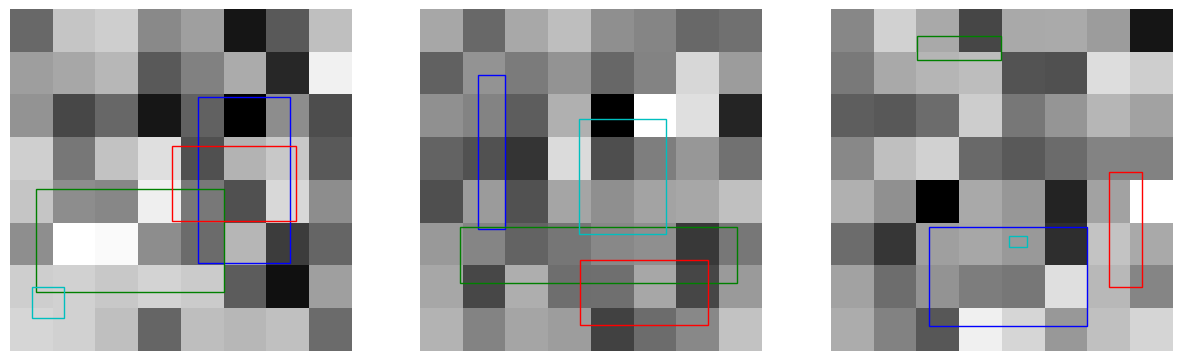

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for batch in range(3):
    axes[batch].imshow(np.mean(feature_maps[batch], axis=-1), cmap='gray')

    for i, roi in enumerate(roi_boxes[batch]):
        x1, y1, x2, y2 = roi
        x1, y1, x2, y2 = x1 + fm_offset, y1 + fm_offset, x2 + fm_offset, y2 + fm_offset
        color = DEFAULT_COLORS[i % len(DEFAULT_COLORS)]

        axes[batch].add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor=color, lw=1))

for ax in axes:
    ax.axis('off')

plt.show()

In [50]:
print(roi_boxes)

tf.Tensor(
[[[3.8878984  1.5490508  6.0544744  5.4409847 ]
  [0.10108709 3.7125359  4.5158167  6.114564  ]
  [3.2880526  2.7071023  6.2030773  4.4575243 ]
  [0.01313698 6.004345   0.7551558  6.72043   ]]

 [[0.8469353  1.044328   1.4796659  4.6376305 ]
  [0.43855727 4.599537   6.9098597  5.9124107 ]
  [3.230618   5.3621664  6.229988   6.885416  ]
  [3.2130141  2.0727777  5.25681    4.7511444 ]]

 [[1.7966967  4.609212   5.488621   6.9200096 ]
  [1.5130103  0.12301183 3.4937248  0.684288  ]
  [6.005362   3.3051891  6.7813144  5.9968777 ]
  [3.6702032  4.813507   4.0947266  5.0713267 ]]], shape=(3, 4, 4), dtype=float32)


In [51]:
len_x = roi_boxes[:, :, 2] - roi_boxes[:, :, 0]
len_y = roi_boxes[:, :, 3] - roi_boxes[:, :, 1]

print(len_x)
print(len_y)

tf.Tensor(
[[2.166576   4.4147296  2.9150248  0.7420188 ]
 [0.6327306  6.4713025  2.99937    2.043796  ]
 [3.6919246  1.9807146  0.77595234 0.42452335]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[3.891934   2.402028   1.750422   0.71608496]
 [3.5933025  1.3128738  1.5232496  2.6783667 ]
 [2.3107977  0.5612762  2.6916885  0.25781965]], shape=(3, 4), dtype=float32)


In [52]:
start_x = roi_boxes[:, :, 0] + len_x / (7 * 4)
start_y = roi_boxes[:, :, 1] + len_y / (7 * 4)

print(start_x)
print(start_y)

tf.Tensor(
[[3.9652762  0.258756   3.3921607  0.03963766]
 [0.8695328  0.66967523 3.3377383  3.286007  ]
 [1.9285511  1.58375    6.0330744  3.6853647 ]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[1.6880485 3.7983227 2.7696173 6.0299196]
 [1.1726602 4.6464252 5.4165683 2.1684337]
 [4.6917405 0.1430574 3.401321  4.822715 ]], shape=(3, 4), dtype=float32)


In [53]:
end_x = roi_boxes[:, :, 2] - len_x / (7 * 4)
end_y = roi_boxes[:, :, 3] - len_y / (7 * 4)

print(end_x)
print(end_y)

tf.Tensor(
[[5.9770966 4.3581476 6.0989695 0.7286551]
 [1.4570683 6.678742  6.1228676 5.1838174]
 [5.3567667 3.422985  6.753602  4.079565 ]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[5.301987   6.028777   4.395009   6.694855  ]
 [4.5092983  5.8655224  6.831014   4.6554885 ]
 [6.837481   0.66424245 5.900746   5.062119  ]], shape=(3, 4), dtype=float32)


In [54]:
sampling_x = tf.linspace(start_x, end_x, 14, axis=-1)
sampling_y = tf.linspace(start_y, end_y, 14, axis=-1)

print(sampling_x)
print(sampling_y)

tf.Tensor(
[[[3.9652762  4.120032   4.274787   4.4295425  4.584298   4.7390532
   4.893809   5.048564   5.2033195  5.358075   5.5128303  5.667586
   5.822341   5.9770966 ]
  [0.258756   0.5740938  0.8894316  1.2047695  1.5201073  1.835445
   2.1507828  2.4661205  2.7814584  3.0967963  3.412134   3.7274718
   4.04281    4.3581476 ]
  [3.3921607  3.6003766  3.8085928  4.016809   4.2250247  4.433241
   4.641457   4.8496733  5.057889   5.266105   5.4743214  5.682537
   5.8907533  6.0989695 ]
  [0.03963766 0.092639   0.14564034 0.19864167 0.251643   0.30464435
   0.3576457  0.41064703 0.46364838 0.5166497  0.569651   0.6226524
   0.6756537  0.7286551 ]]

 [[0.8695328  0.91472787 0.9599229  1.0051179  1.050313   1.095508
   1.1407031  1.1858981  1.2310932  1.2762882  1.3214833  1.3666782
   1.4118733  1.4570683 ]
  [0.66967523 1.1319112  1.594147   2.056383   2.5186188  2.9808545
   3.4430904  3.9053264  4.3675623  4.829798   5.292034   5.75427
   6.216506   6.678742  ]
  [3.3377383  3.55197

In [55]:
sampling_x = tf.reshape(sampling_x, [3, 4, 14, 1, 1])
sampling_y = tf.reshape(sampling_y, [3, 4, 1, 14, 1])

sampling_x = tf.broadcast_to(sampling_x, [3, 4, 14, 14, 1])
sampling_y = tf.broadcast_to(sampling_y, [3, 4, 14, 14, 1])

sampling_x = tf.reshape(sampling_x, [3, 4, 14 * 14, 1])
sampling_y = tf.reshape(sampling_y, [3, 4, 14 * 14, 1])

sampling_points = tf.concat([sampling_x, sampling_y], axis=-1)

print(sampling_points.shape)
print(sampling_points)

(3, 4, 196, 2)
tf.Tensor(
[[[[3.9652762  1.6880485 ]
   [3.9652762  1.9660437 ]
   [3.9652762  2.244039  ]
   ...
   [5.9770966  4.7459965 ]
   [5.9770966  5.023992  ]
   [5.9770966  5.301987  ]]

  [[0.258756   3.7983227 ]
   [0.258756   3.969896  ]
   [0.258756   4.1414695 ]
   ...
   [4.3581476  5.6856303 ]
   [4.3581476  5.8572035 ]
   [4.3581476  6.028777  ]]

  [[3.3921607  2.7696173 ]
   [3.3921607  2.8946474 ]
   [3.3921607  3.0196776 ]
   ...
   [6.0989695  4.144949  ]
   [6.0989695  4.269979  ]
   [6.0989695  4.395009  ]]

  [[0.03963766 6.0299196 ]
   [0.03963766 6.0810685 ]
   [0.03963766 6.1322174 ]
   ...
   [0.7286551  6.5925574 ]
   [0.7286551  6.6437063 ]
   [0.7286551  6.694855  ]]]


 [[[0.8695328  1.1726602 ]
   [0.8695328  1.4293246 ]
   [0.8695328  1.6859891 ]
   ...
   [1.4570683  3.9959693 ]
   [1.4570683  4.2526336 ]
   [1.4570683  4.5092983 ]]

  [[0.66967523 4.6464252 ]
   [0.66967523 4.740202  ]
   [0.66967523 4.8339787 ]
   ...
   [6.678742   5.677969  ]
  

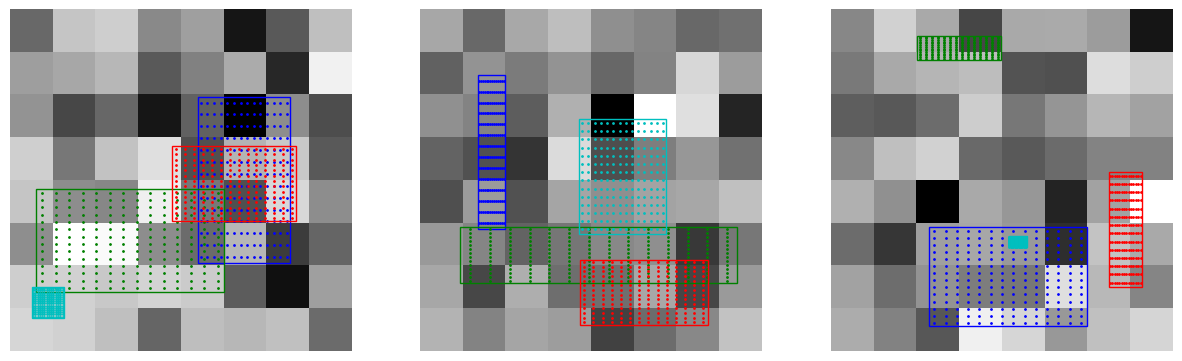

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for batch in range(3):
    axes[batch].imshow(np.mean(feature_maps[batch], axis=-1), cmap='gray')

    for i, roi in enumerate(roi_boxes[batch]):
        x1, y1, x2, y2 = roi
        x1, y1, x2, y2 = x1 + fm_offset, y1 + fm_offset, x2 + fm_offset, y2 + fm_offset
        color = DEFAULT_COLORS[i % len(DEFAULT_COLORS)]

        axes[batch].add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor=color, lw=1))
        axes[batch].scatter(sampling_points[batch, i, :, 0] + fm_offset, sampling_points[batch, i, :, 1] + fm_offset, c=color, s=1)

for ax in axes:
    ax.axis('off')

plt.show()

In [57]:
x_1 = tf.math.floor(sampling_points[..., 0])
y_1 = tf.math.floor(sampling_points[..., 1])
x_2 = tf.math.ceil(sampling_points[..., 0])
y_2 = tf.math.ceil(sampling_points[..., 1])

f_11 = tf.stack([x_1, y_1], axis=-1)
f_12 = tf.stack([x_2, y_1], axis=-1)
f_21 = tf.stack([x_1, y_2], axis=-1)
f_22 = tf.stack([x_2, y_2], axis=-1)

w_11 = (x_2 - sampling_points[..., 0]) * (y_2 - sampling_points[..., 1])
w_12 = (sampling_points[..., 0] - x_1) * (y_2 - sampling_points[..., 1])
w_21 = (x_2 - sampling_points[..., 0]) * (sampling_points[..., 1] - y_1)
w_22 = (sampling_points[..., 0] - x_1) * (sampling_points[..., 1] - y_1)

print(x_1.shape)
print(f_11.shape)
print(w_11.shape)

(3, 4, 196)
(3, 4, 196, 2)
(3, 4, 196)


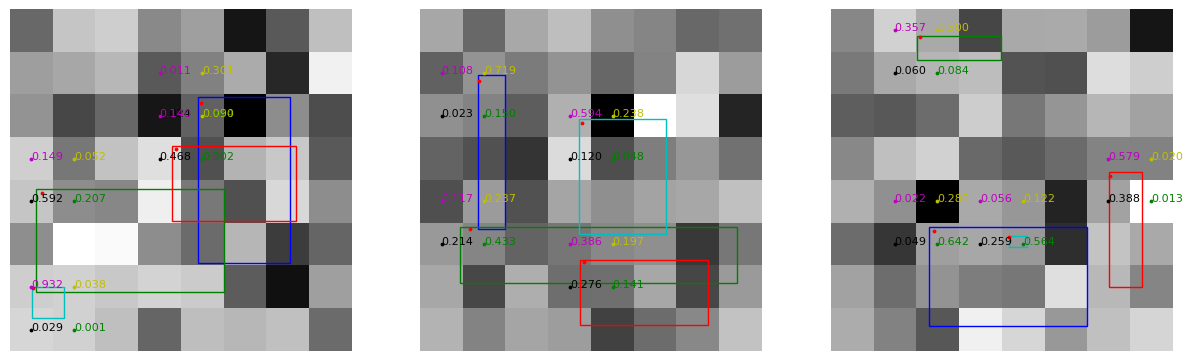

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for batch in range(3):
    axes[batch].imshow(np.mean(feature_maps[batch], axis=-1), cmap='gray')

    for i, roi in enumerate(roi_boxes[batch]):
        x1, y1, x2, y2 = roi
        x1, y1, x2, y2 = x1 + fm_offset, y1 + fm_offset, x2 + fm_offset, y2 + fm_offset
        color = DEFAULT_COLORS[i % len(DEFAULT_COLORS)]

        axes[batch].add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor=color, lw=1))
        axes[batch].scatter(sampling_points[batch, i, 0, 0] + fm_offset, sampling_points[batch, i, 0, 1] + fm_offset, c='r', s=3)

        axes[batch].scatter(f_11[batch, i, 0, 0] + fm_offset, f_11[batch, i, 0, 1] + fm_offset, c='m', s=3)
        axes[batch].scatter(f_12[batch, i, 0, 0] + fm_offset, f_12[batch, i, 0, 1] + fm_offset, c='y', s=3)
        axes[batch].scatter(f_21[batch, i, 0, 0] + fm_offset, f_21[batch, i, 0, 1] + fm_offset, c='k', s=3)
        axes[batch].scatter(f_22[batch, i, 0, 0] + fm_offset, f_22[batch, i, 0, 1] + fm_offset, c='g', s=3)

        axes[batch].text(f_11[batch, i, 0, 0] + fm_offset, f_11[batch, i, 0, 1] + fm_offset, '{:.3f}'.format(w_11[batch, i, 0]), color='m', fontsize=8)
        axes[batch].text(f_12[batch, i, 0, 0] + fm_offset, f_12[batch, i, 0, 1] + fm_offset, '{:.3f}'.format(w_12[batch, i, 0]), color='y', fontsize=8)
        axes[batch].text(f_21[batch, i, 0, 0] + fm_offset, f_21[batch, i, 0, 1] + fm_offset, '{:.3f}'.format(w_21[batch, i, 0]), color='k', fontsize=8)
        axes[batch].text(f_22[batch, i, 0, 0] + fm_offset, f_22[batch, i, 0, 1] + fm_offset, '{:.3f}'.format(w_22[batch, i, 0]), color='g', fontsize=8)

for ax in axes:
    ax.axis('off')

plt.show()

In [59]:
w_11 = tf.expand_dims(w_11, axis=-1)
w_12 = tf.expand_dims(w_12, axis=-1)
w_21 = tf.expand_dims(w_21, axis=-1)
w_22 = tf.expand_dims(w_22, axis=-1)

f_11 = tf.cast(f_11, tf.int32)
f_12 = tf.cast(f_12, tf.int32)
f_21 = tf.cast(f_21, tf.int32)
f_22 = tf.cast(f_22, tf.int32)

print(f_12[2, 2, 185])

interpolated_points = w_11 * tf.gather_nd(feature_maps, f_11, batch_dims=1) + \
                      w_12 * tf.gather_nd(feature_maps, f_12, batch_dims=1) + \
                      w_21 * tf.gather_nd(feature_maps, f_21, batch_dims=1) + \
                      w_22 * tf.gather_nd(feature_maps, f_22, batch_dims=1)

print(interpolated_points)

tf.Tensor([7 3], shape=(2,), dtype=int32)
tf.Tensor(
[[[[8.307257   7.8556547  4.077968   ... 3.3324125  8.821664
    8.359263  ]
   [8.596778   9.437203   5.6035943  ... 4.578155   9.1165905
    8.759569  ]
   [6.8313246  9.100747   6.4526434  ... 4.293364   8.780602
    6.7667885 ]
   ...
   [8.260293   5.48553    4.4321284  ... 4.509088   8.768571
    0.6717683 ]
   [9.041469   6.944758   2.8376286  ... 3.7199829  8.7131815
    0.6391992 ]
   [7.5536118  6.968814   3.6109948  ... 3.4752262  6.4656835
    0.8544214 ]]

  [[5.496981   5.3299847  4.752045   ... 7.9337544  6.3619356
    6.2447977 ]
   [5.1124525  5.118024   3.7631996  ... 8.158734   6.9628024
    7.0972195 ]
   [5.1547227  5.3815055  4.3084497  ... 7.5631185  6.9709115
    6.683266  ]
   ...
   [3.2538984  4.1216097  2.503697   ... 5.669276   2.748
    4.642141  ]
   [3.4087844  4.2235603  2.4813662  ... 5.8539696  2.604059
    3.9768631 ]
   [3.6188228  4.3282623  2.4664237  ... 6.0053797  2.5324368
    3.4903574 ]]

 

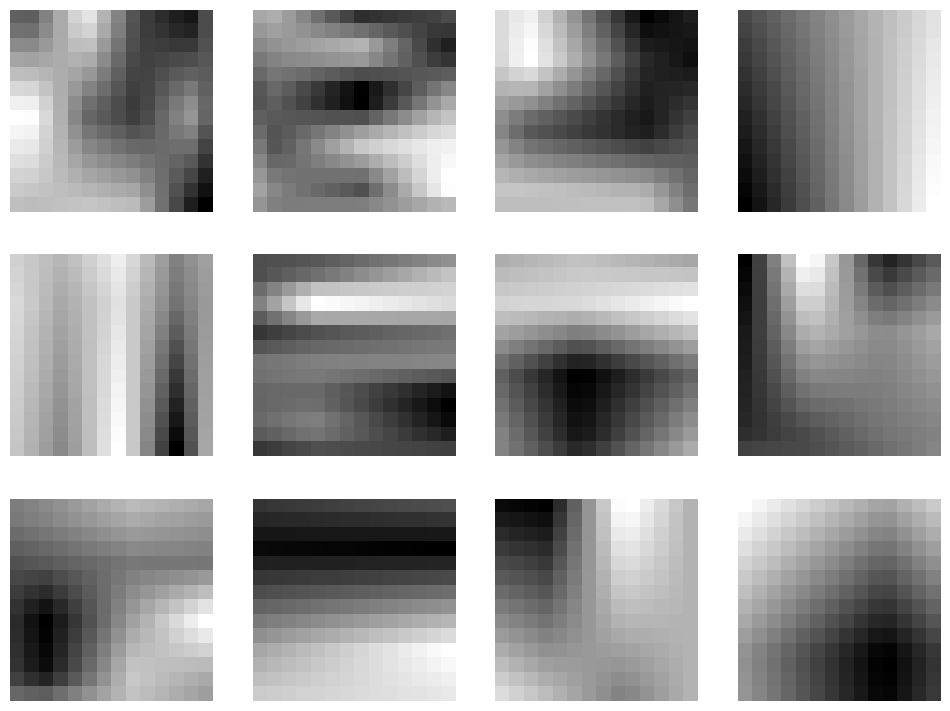

In [60]:
interpolated_points = tf.reshape(interpolated_points, [3, 4, 14, 14, 2048])

fig, axes = plt.subplots(3, 4, figsize=(12, 9))

for batch in range(3):
    for roi in range(4):
        axes[batch, roi].imshow(np.mean(interpolated_points[batch, roi], axis=-1), cmap='gray')

for ax in axes.flatten():
    ax.axis('off')

plt.show()